<a href="https://colab.research.google.com/github/farghea/database_for_mechanical_mechanism/blob/main/3-%20plot_figure1_table1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_url = 'https://drive.google.com/file/d/1yC6nKih8HcAAoKCVM-Lo6bxGQ2O8T5-_/view?usp=sharing'
file_id = file_url.split('/')[5]

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('combined_dataset.zip')

print('File downloaded successfully.')


File downloaded successfully.


In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(zip_path):
        print(f"The file {zip_path} does not exist.")
        return

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted all files to {extract_to}")


unzip_file(
    zip_path='/content/combined_dataset.zip',
    extract_to='/content')


Extracted all files to /content


In [ ]:
import json

file_path = '/content/combined_dataset_256x/metadata.jsonl'

with open(file_path, 'r') as infile:
    lines = infile.readlines()


first_n_characters = 150
processed_lines = []
for line in lines:
    data = json.loads(line)

    if 'text' in data:
        if len(data['text']) > first_n_characters:
            data['text'] = data['text'][:first_n_characters] + " ..."
        else:
            data['text'] = data['text'][:first_n_characters]

    processed_lines.append(json.dumps(data) + '\n')

with open(file_path, 'w') as outfile:
    outfile.writelines(processed_lines)


In [ ]:
from datasets import load_dataset

dataset = load_dataset("/content/combined_dataset_256x", split="train")
dataset = dataset.shuffle(seed=42)

Resolving data files:   0%|          | 0/8994 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

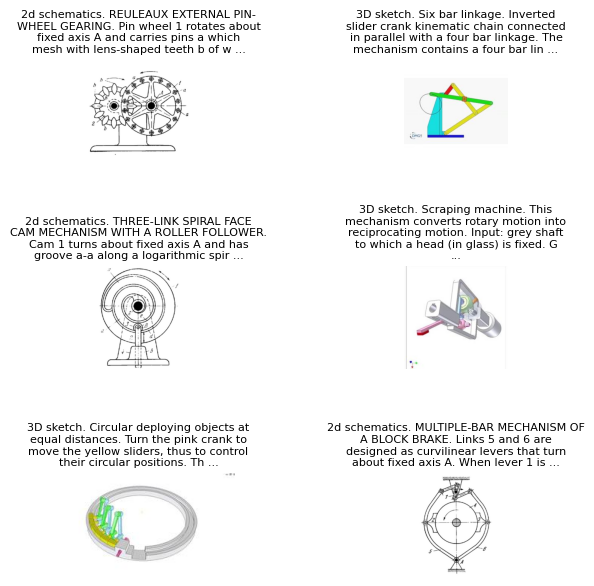

In [ ]:
import matplotlib.pyplot as plt
import random
import textwrap

n_rows = 3
n_cols = 2

random.seed(81)
indices = random.sample(range(0, len(dataset)), n_rows*n_cols)

cm2inch = 1/2.54
fig_width = 18 * cm2inch
fig_height = 15 * cm2inch
plt.figure(figsize=(fig_width, fig_height))

max_title_length = 40

for i, indx in enumerate(indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(dataset[indx]["image"])

    wrapped_title = "\n".join(textwrap.wrap(dataset[indx]["text"], max_title_length))
    plt.title(wrapped_title, fontsize=8, pad=20, y=0.8)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=1.0)
plt.savefig("figure1.jpg", dpi=500, bbox_inches='tight', pad_inches=0.1, format='jpg')
plt.show()





In [ ]:
import json
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.util import ngrams
from nltk import word_tokenize


nltk.download('punkt')
nltk.download('stopwords')

def normalize_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def get_second_sentence(text):
    sentences = sent_tokenize(text)
    if len(sentences) > 1:
        return sentences[1]
    return None


file_path = 'your_json_file.json'
data = load_json(file_path)

# Extract second sentences and normalize
second_sentences = [normalize_text(get_second_sentence(item)) for item in data if get_second_sentence(item)]

phrases = []
for sentence in second_sentences:
    tokens = word_tokenize(sentence)
    for n in range(1, 4):
        n_grams = list(ngrams(tokens, n))
        phrases.extend([' '.join(gram) for gram in n_grams])

phrase_counts = Counter(phrases)

top_10_phrases = phrase_counts.most_common(10)

print("Top 10 Phrases:")
for phrase, count in top_10_phrases:
    print(f"{phrase}: {count}")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(phrase_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
